In [1]:
import random

import torch
import numpy as np
from bindsnet.network import Network
from bindsnet.network.nodes import Input
from bindsnet.learning.learning import MSTDPET, PostPre, NoOp
from bindsnet.network.topology import Connection
from bindsnet.network.monitors import Monitor

from libs.learning import PostPreInh, MSTDPET_SEASONAL, MSTDP_SEASONAL, RSTDP_SEASONAL, AbstractSeasonalLearning
from libs.second_appr_simp_t2 import CorticalColumn, LayerConnection, ComplexStructure, LAYER_23, LAYER_4
from libs.connections import ConnectionWithConvergence, RandomConnection, MaxPool1dConnection, get_output_size_maxpool1d

In [2]:
model_name = 'c2'
seed = random.randint(0,9999999)
print(seed)

9906699


In [3]:
# seed = 1400
random.seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)

In [4]:
input_size = 200
each_session = 40
session_number = 1000
# layer23_involve_from = 500
gap_time = 20

time = session_number * each_session
spike_train = torch.zeros(time, input_size).bool()
timestep_class = torch.zeros(time).bool()

session_class = torch.rand(session_number) < 0.5
# session_class = torch.tensor(([True, False] * int((session_number + 1) / 2))[:session_number])

active_fire_rate = 0.2
pattern_size = int(input_size/2)

for idx, cls in enumerate(session_class):
    passive_noise = torch.rand(each_session, input_size) < 0.01 + (random.random() * 0.01 - 0.005)
    spike_train[idx * each_session: (idx + 1) * each_session, :] = passive_noise
    if cls:
        pattern_1 = torch.rand(each_session, pattern_size) < active_fire_rate
        pattern_1[each_session - gap_time:, :] = 0
        spike_train[idx * each_session: (idx + 1) * each_session, :int(input_size/2)] |= pattern_1
    else:
        pattern_2 = torch.rand(each_session, pattern_size) < active_fire_rate
        pattern_2[each_session - gap_time:, :] = 0
        spike_train[idx * each_session: (idx + 1) * each_session, int(input_size/2):] |= pattern_2
    
    timestep_class[idx * each_session: (idx + 1) * each_session] = cls

In [5]:
spike_train.T[:, 100:]

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

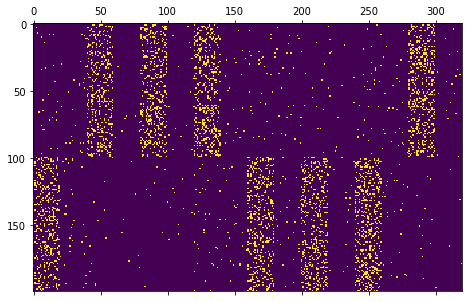

In [6]:
import matplotlib.pyplot as plt

plt.matshow(spike_train.T[:, :8 * each_session])

In [7]:
connection_args = { # Between Layer
    'kernel_size': 5,
    'stride': 3
}
layer_args_l23 = {
    'exc_size': get_output_size_maxpool1d(100, 5, 3),
    'inh_con_args': { # Inside Layer
        'wmin': -1.5,
        'wmax': 0,
        'update_rule': NoOp,
        'probability': 1.0,
    },
    'exc_args': {
        'thresh': -52.0,
        'tc_trace': 10,
        'traces': True,
        'tc_decay': 10,
        'refrac': 3,
    }
}
layer_args_l4 = {
    'exc_size': 100,
    'inh_con_args': { # Inside Layer
        'wmin': -0.5,
        'wmax': 0,
        'update_rule': NoOp,
        'probability': 0.30,
    },
    'exc_args': {
        'thresh': -52.0,
        'tc_trace': 6,
        'traces': True,
        'tc_decay': 10,
        'refrac': 3,
#         'rest':-57
    }
}
connection_type = RandomConnection

In [8]:
input_pop_c1 = Input(input_size, traces=True, tc_trace=6)
input_name = f'input_{model_name}'
c1 = CorticalColumn(connection_args, layer_args_l23, layer_args_l4, name=model_name, monitor=LAYER_23|LAYER_4)
input_to_c1_connection = LayerConnection((input_name, input_pop_c1), c1, connection_type, {
    'wmin': 0.,
    'wmax': 0.8,
    'nu': [0.02, 0.01],
#     'update_rule': PostPre,
    'probability': 0.30,
    
    'update_rule': MSTDPET_SEASONAL,
    'tc_plus': 6,
    'tc_minus': 6, 
    'tc_e_trace': 6,
})

In [9]:
c1_with_input = ComplexStructure()
c1_with_input.add_pop(input_name, input_pop_c1)
c1_with_input.add_submodule(c1)
c1_with_input.add_submodule(input_to_c1_connection)
c1_with_input.add_outpops(c1.get_output_pops())

In [10]:
network = Network(dt=1.0)
c1_with_input.add_to_network(network)

bl_monitors = []
bl_monitors_name = []
for a, b, con in input_to_c1_connection.connections:
    tmp = Monitor(obj=con, state_vars=['converge'])
    network.add_monitor(monitor=tmp, name=f"{a}_{b}_connection_monitor")
    bl_monitors.append(tmp)
    bl_monitors_name.append((a, b))
    

In [11]:
# Disable layer 2,3
# c1.l23.disable_learning()
# c1.l4_l23.disable_learning()

In [12]:
from tqdm import trange

rewards = []
changes = []
activities = []
# inputs = {'input_c1' : spike_train}
for part in trange(session_number, unit="parts"):
# for part in trange(1, unit="parts"):

#     if part == layer23_involve_from:
#         c1.l4.disable_learning()
#         input_to_c1_connection.disable_learning()
        
#         c1.l23.enable_learning()
#         c1.l4_l23.enable_learning()
        
        
    inp = {input_name: spike_train[part*each_session:part*each_session+each_session, :]}
    network.run(inputs=inp, time=each_session)
    
    avg_sessions = 10
    in_use_sessions = min(part + 1, avg_sessions)
    exc1_avg = c1.l23.monitors[0][1].get('s')[-each_session * in_use_sessions:,0,:].sum() / in_use_sessions
    exc2_avg = c1.l23.monitors[1][1].get('s')[-each_session * in_use_sessions:,0,:].sum() / in_use_sessions
    
    exc1_act = c1.l23.monitors[0][1].get('s')[-each_session:,0,:].sum()# - exc1_avg
    exc2_act = c1.l23.monitors[1][1].get('s')[-each_session:,0,:].sum()# - exc2_avg
    
    activities.append((exc1_act, exc2_act))
    
    pattern = session_class[part]
    gap = abs(exc2_act - exc1_act) / layer_args_l23['exc_size']  #  In Range 0-1
    gap_check = abs(exc2_act - exc1_act) / layer_args_l23['exc_size'] > 0.3
    
    exc1_wins = exc1_act > exc2_act
    
    if pattern == exc1_wins and gap_check:
        reward = 1.0 + gap
    elif pattern == exc1_wins:
        reward = -0.1 + gap
    else:
        reward = -1 - gap
    
#     if pattern and exc1_act > 20 and exc2_act < 10:
#         reward = 1.0 + gap
#     elif not pattern and exc2_act > 20 and exc1_act < 10:
#         reward = 1.0 + gap
#     elif exc1_wins != pattern:
#         reward = -1 - gap
#     else:
#         reward = -0.1
        
    rewards.append(reward)
    
    for conn in input_to_c1_connection.connections:
        if isinstance(conn[2].update_rule, AbstractSeasonalLearning):
            change = conn[2].update_rule.trigger(reward)
            changes.append(change)
    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:13<00:00,  7.50parts/s]


In [13]:
# c1.l23.disable_learning()
# c1.l4_l23.disable_learning

In [14]:
rewards[-300:]

[tensor(4.6562),
 tensor(4.5000),
 tensor(4.3750),
 tensor(4.2500),
 tensor(4.4375),
 tensor(4.5625),
 tensor(4.5625),
 tensor(4.1562),
 tensor(4.5938),
 tensor(4.5625),
 tensor(4.5625),
 tensor(4.6875),
 tensor(4.3438),
 tensor(4.5000),
 tensor(4.4062),
 tensor(4.4062),
 tensor(4.5938),
 tensor(4.4688),
 tensor(4.9375),
 tensor(4.3750),
 tensor(4.3750),
 tensor(4.4375),
 tensor(4.7500),
 tensor(4.6250),
 tensor(4.4375),
 tensor(4.5938),
 tensor(4.4688),
 tensor(4.6250),
 tensor(4.9375),
 tensor(4.5938),
 tensor(4.2812),
 tensor(4.4375),
 tensor(4.3750),
 tensor(4.9062),
 tensor(4.4688),
 tensor(4.6250),
 tensor(4.5000),
 tensor(4.5625),
 tensor(4.5000),
 tensor(4.7812),
 tensor(4.7500),
 tensor(4.1875),
 tensor(4.6875),
 tensor(4.7188),
 tensor(4.5000),
 tensor(4.4062),
 tensor(4.4062),
 tensor(4.8438),
 tensor(4.6562),
 tensor(4.5000),
 tensor(4.3438),
 tensor(4.8750),
 tensor(4.9375),
 tensor(4.6250),
 tensor(4.7500),
 tensor(4.6562),
 tensor(5.),
 tensor(4.5938),
 tensor(4.3750),
 

In [15]:
session_class[-300:]

tensor([False,  True, False,  True, False,  True,  True,  True,  True,  True,
         True, False,  True,  True, False,  True,  True, False,  True,  True,
        False,  True, False,  True,  True, False,  True,  True,  True, False,
         True, False, False, False,  True,  True,  True, False, False, False,
         True,  True,  True,  True, False,  True, False, False,  True, False,
        False, False, False,  True,  True, False, False,  True, False, False,
        False,  True,  True,  True, False, False, False, False,  True, False,
        False, False, False, False, False,  True, False,  True, False, False,
         True, False, False,  True,  True, False,  True, False, False,  True,
         True,  True,  True, False, False, False, False,  True, False,  True,
        False,  True, False, False, False,  True,  True,  True, False,  True,
        False, False, False, False,  True,  True,  True, False, False, False,
        False, False,  True, False,  True, False,  True, False, 

In [16]:
# for i in range(100):
#     x = torch.linspace(-0.05, 0.05, steps=40)
#     plt.bar(x, torch.histc(changes[i], bins=40, min=-0.05, max=0.05), align='center', width=0.002)
#     plt.figure()

## Convergence

('input_c2', 'c2_l4__exc1')
('input_c2', 'c2_l4__exc2')


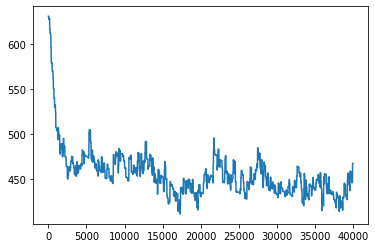

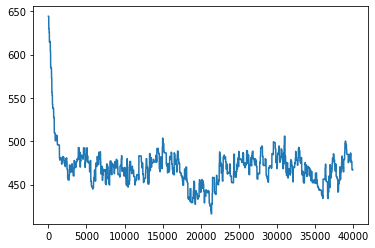

In [17]:
for name, m in zip(bl_monitors_name, bl_monitors):
    print(name)
    plt.figure()
    plt.plot(m.get('converge'))

In [18]:
# plt.plot(inp_2_c1_monitor_1.get('converge'))
# plt.figure()
# plt.plot(inp_2_c1_monitor_2.get('converge'))

In [19]:
time_show = time

In [20]:
spikes = {
    "L4 | 1": c1.l4.monitors[0][1].get('s')[-time_show:,0,:].T, 
    "L4 | 2": c1.l4.monitors[1][1].get('s')[-time_show:,0,:].T, 
    
    "L23 | 1": c1.l23.monitors[0][1].get('s')[-time_show:,0,:].T, 
    "L23 | 2": c1.l23.monitors[1][1].get('s')[-time_show:,0,:].T,
}

## Confusion

### Layer 4

In [21]:
print(f"L4 -- Excitatory 1 -- Pattern 1     :    {spikes['L4 | 1'][:, -1500:][:, timestep_class[-1500:]].sum() / session_class[-50:].sum()}")
print(f"L4 -- Excitatory 1 -- Pattern 2     :    {spikes['L4 | 1'][:, -1500:][:, ~ timestep_class[-1500:]].sum() / (~ session_class)[-50:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 1     :    {spikes['L4 | 2'][:, -1500:][:, timestep_class[-1500:]].sum() / session_class[-50:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 2     :    {spikes['L4 | 2'][:, -1500:][:, ~ timestep_class[-1500:]].sum() / (~ session_class)[-50:].sum()}")

L4 -- Excitatory 1 -- Pattern 1     :    232.9499969482422
L4 -- Excitatory 1 -- Pattern 2     :    0.13333334028720856
L4 -- Excitatory 2 -- Pattern 1     :    0.5
L4 -- Excitatory 2 -- Pattern 2     :    200.8333282470703


In [22]:
print(f"L4 -- Excitatory 1 -- Pattern 1     :    {spikes['L4 | 1'][:, -3000:][:, timestep_class[-3000:]].sum() / session_class[-100:].sum()}")
print(f"L4 -- Excitatory 1 -- Pattern 2     :    {spikes['L4 | 1'][:, -3000:][:, ~ timestep_class[-3000:]].sum() / (~ session_class)[-100:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 1     :    {spikes['L4 | 2'][:, -3000:][:, timestep_class[-3000:]].sum() / session_class[-100:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 2     :    {spikes['L4 | 2'][:, -3000:][:, ~ timestep_class[-3000:]].sum() / (~ session_class)[-100:].sum()}")

L4 -- Excitatory 1 -- Pattern 1     :    202.9512176513672
L4 -- Excitatory 1 -- Pattern 2     :    0.23728813230991364
L4 -- Excitatory 2 -- Pattern 1     :    0.31707316637039185
L4 -- Excitatory 2 -- Pattern 2     :    224.8135528564453


In [23]:
print(f"L4 -- Excitatory 1 -- Pattern 1     :    {spikes['L4 | 1'][:, timestep_class].sum() / session_class.sum()}")
print(f"L4 -- Excitatory 1 -- Pattern 2     :    {spikes['L4 | 1'][:, ~ timestep_class].sum() / (~ session_class).sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 1     :    {spikes['L4 | 2'][:, timestep_class].sum() / session_class.sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 2     :    {spikes['L4 | 2'][:, ~ timestep_class].sum() / (~ session_class).sum()}")

L4 -- Excitatory 1 -- Pattern 1     :    283.4795227050781
L4 -- Excitatory 1 -- Pattern 2     :    0.83203125
L4 -- Excitatory 2 -- Pattern 1     :    1.1209015846252441
L4 -- Excitatory 2 -- Pattern 2     :    286.142578125


### Layer 2,3

In [24]:
print(f"L4 -- Excitatory 1 -- Pattern 1     :    {spikes['L23 | 1'][:, -1500:][:, timestep_class[-1500:]].sum() / session_class[-50:].sum()}")
print(f"L4 -- Excitatory 1 -- Pattern 2     :    {spikes['L23 | 1'][:, -1500:][:, ~ timestep_class[-1500:]].sum() / (~ session_class)[-50:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 1     :    {spikes['L23 | 2'][:, -1500:][:, timestep_class[-1500:]].sum() / session_class[-50:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 2     :    {spikes['L23 | 2'][:, -1500:][:, ~ timestep_class[-1500:]].sum() / (~ session_class)[-50:].sum()}")

L4 -- Excitatory 1 -- Pattern 1     :    90.0
L4 -- Excitatory 1 -- Pattern 2     :    0.20000000298023224
L4 -- Excitatory 2 -- Pattern 1     :    0.75
L4 -- Excitatory 2 -- Pattern 2     :    80.03333282470703


In [25]:
print(f"L23 -- Excitatory 1 -- Pattern 1     :    {spikes['L23 | 1'][:, -3000:][:, timestep_class[-3000:]].sum() / session_class[-100:].sum()}")
print(f"L23 -- Excitatory 1 -- Pattern 2     :    {spikes['L23 | 1'][:, -3000:][:, ~ timestep_class[-3000:]].sum() / (~ session_class)[-100:].sum()}")
print(f"L23 -- Excitatory 2 -- Pattern 1     :    {spikes['L23 | 2'][:, -3000:][:, timestep_class[-3000:]].sum() / session_class[-100:].sum()}")
print(f"L23 -- Excitatory 2 -- Pattern 2     :    {spikes['L23 | 2'][:, -3000:][:, ~ timestep_class[-3000:]].sum() / (~ session_class)[-100:].sum()}")

L23 -- Excitatory 1 -- Pattern 1     :    79.26829528808594
L23 -- Excitatory 1 -- Pattern 2     :    0.35593220591545105
L23 -- Excitatory 2 -- Pattern 1     :    0.4878048896789551
L23 -- Excitatory 2 -- Pattern 2     :    90.18643951416016


In [26]:
print(f"L23 -- Excitatory 1 -- Pattern 1     :    {spikes['L23 | 1'][:, timestep_class].sum() / session_class.sum()}")
print(f"L23 -- Excitatory 1 -- Pattern 2     :    {spikes['L23 | 1'][:, ~ timestep_class].sum() / (~ session_class).sum()}")
print(f"L23 -- Excitatory 2 -- Pattern 1     :    {spikes['L23 | 2'][:, timestep_class].sum() / session_class.sum()}")
print(f"L23 -- Excitatory 2 -- Pattern 2     :    {spikes['L23 | 2'][:, ~ timestep_class].sum() / (~ session_class).sum()}")

L23 -- Excitatory 1 -- Pattern 1     :    113.0655746459961
L23 -- Excitatory 1 -- Pattern 2     :    0.8125
L23 -- Excitatory 2 -- Pattern 1     :    1.1065573692321777
L23 -- Excitatory 2 -- Pattern 2     :    115.61328125


## Pattern Separation

In [27]:
for source, target, connection in input_to_c1_connection.connections:
    print(f"{source} (0:99)    --->   {target}   :   {connection.w[:100, :].sum()}")
    print(f"{source} (100:199) --->   {target}   :   {connection.w[100:, :].sum()}")

input_c2 (0:99)    --->   c2_l4__exc1   :   2027.0279541015625
input_c2 (100:199) --->   c2_l4__exc1   :   964.120849609375
input_c2 (0:99)    --->   c2_l4__exc2   :   958.04931640625
input_c2 (100:199) --->   c2_l4__exc2   :   1998.763671875


In [28]:
# for source, target, connection in c1.l4_l23.connections:
#     print(f"{source}   --->   {target}   :   {connection.w.sum()}")

## Activities

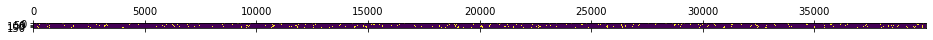

In [29]:
plt.matshow(spike_train.T[:, -time_show:])

In [30]:
c1.l4.monitors[0][1].get('s').shape

torch.Size([40000, 1, 100])

In [31]:
spikes["L4 | 1"].shape

torch.Size([100, 40000])

In [32]:
spikes["L4 | 1"].sum(0).shape[0]

40000

In [33]:
spikes["L4 | 1"][:,-150:]

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

In [34]:
spikes["L4 | 1"][:,-300:-270].sum()

tensor(9)

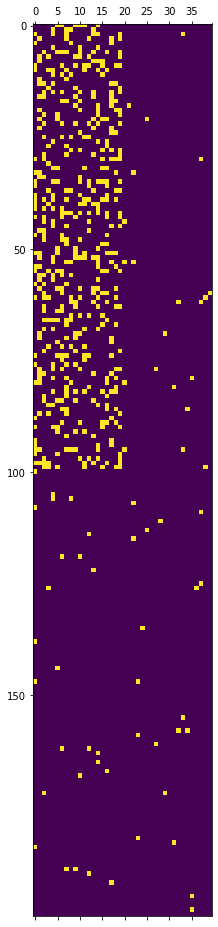

In [35]:
x = 999
plt.matshow(spike_train.T[:, x * each_session:x * each_session + each_session])

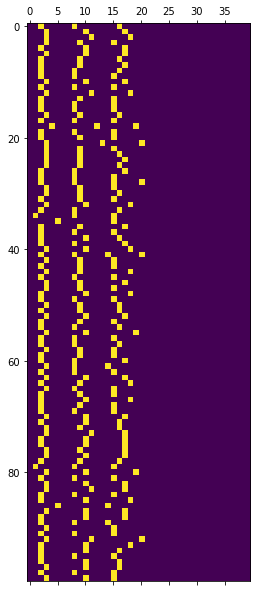

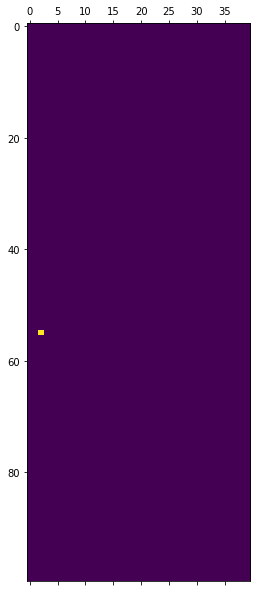

In [36]:
x = 999
plt.matshow(spikes["L4 | 1"][:, x * each_session:x * each_session + each_session])
plt.matshow(spikes["L4 | 2"][:, x * each_session:x * each_session + each_session])

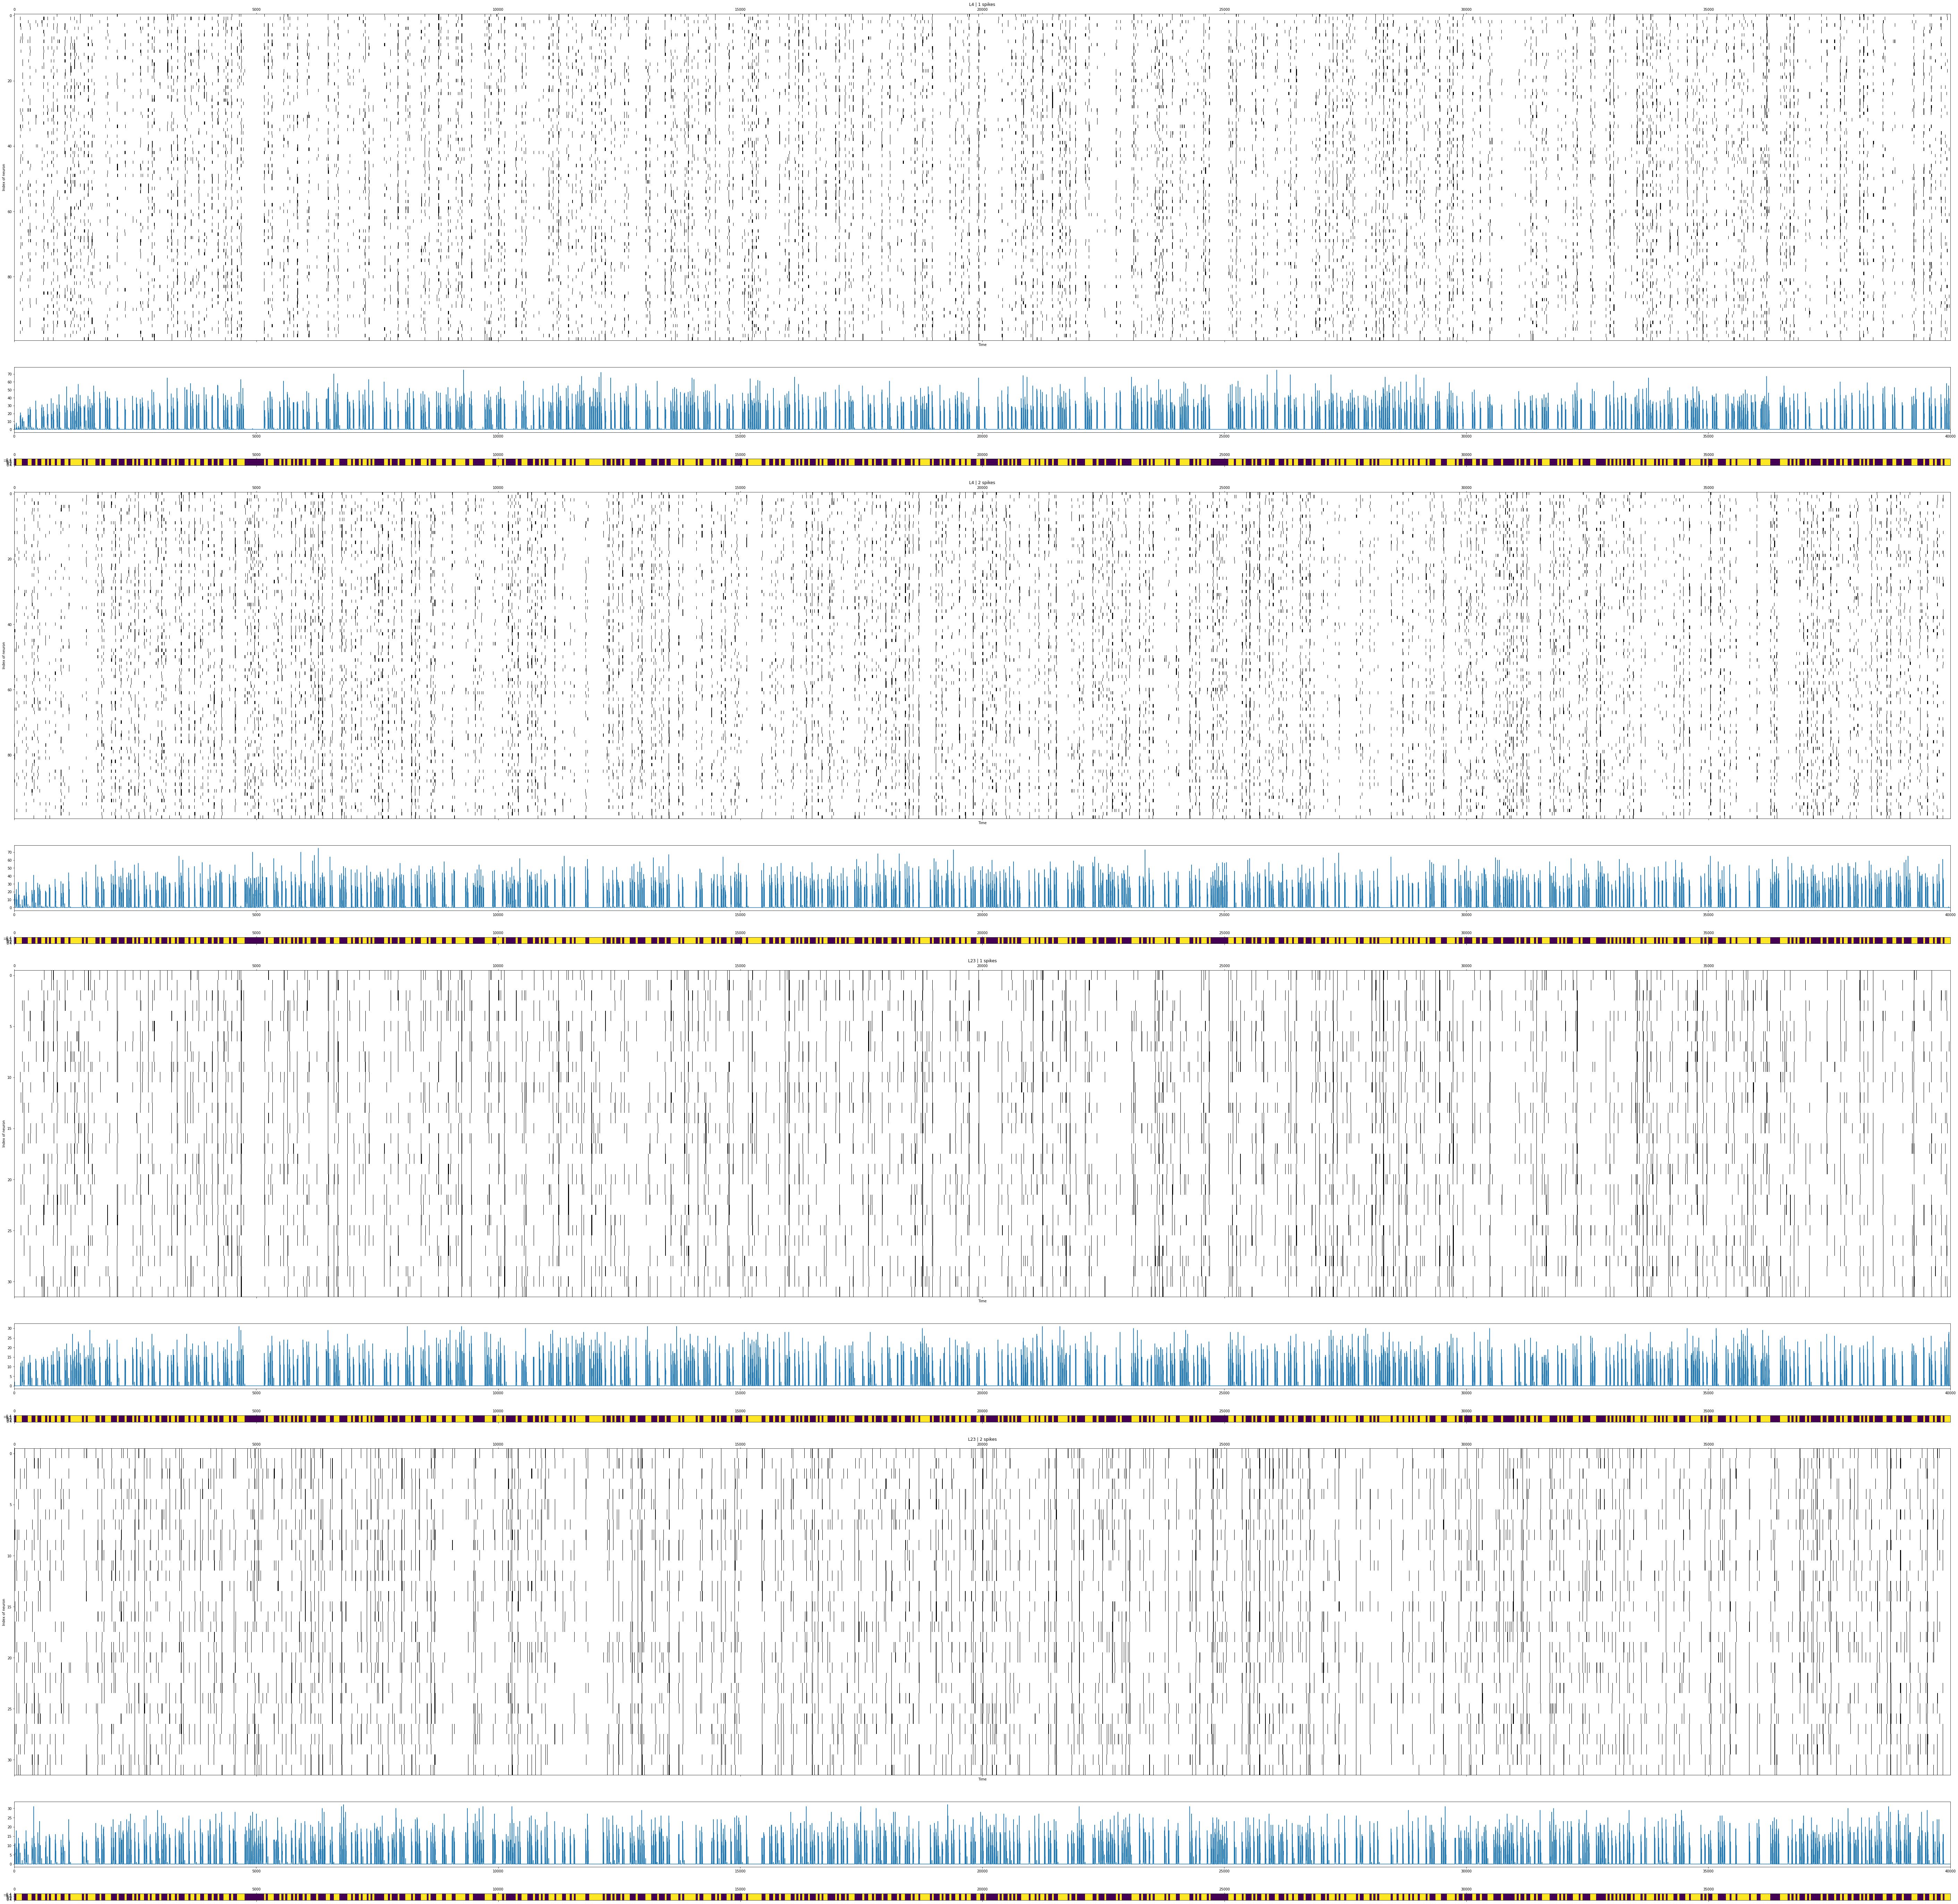

In [37]:
ver_num = len(spikes)
fig, axes = plt.subplots(ver_num * 3, 1, figsize=(100, 100), gridspec_kw={'height_ratios': [50, 10, 1] * ver_num})
# fig.suptitle(f"Spikes: t={start_time}-{end_time}")
for idx, layer in enumerate(spikes):
    indx = idx * 3
    axes[indx].matshow(spikes[layer], cmap='Greys')
    axes[indx].set_title('%s spikes' % layer)
    axes[indx].set_xlabel('Time')
    axes[indx].set_ylabel('Index of neuron')
    axes[indx].set_aspect('auto')
    
    activity = spikes[layer].sum(0)
    axes[indx + 1].plot(activity)
    axes[indx + 1].set_aspect('auto')
    axes[indx + 1].set_xlim([0, activity.shape[0]])
    
    axes[indx + 2].matshow(timestep_class[-time_show:].unsqueeze(1).T)
    axes[indx + 2].set_aspect('auto')

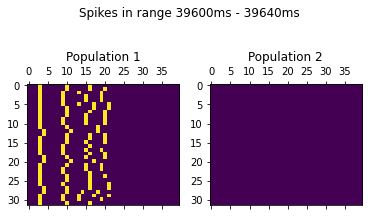

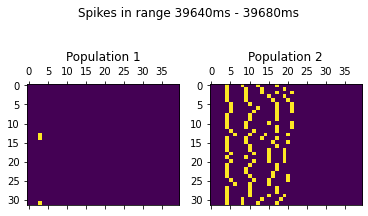

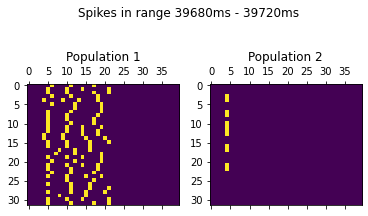

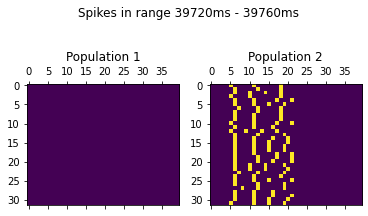

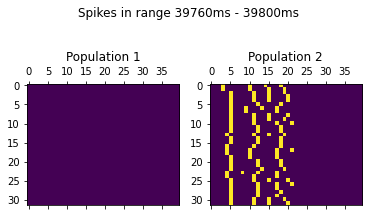

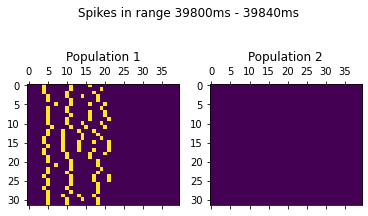

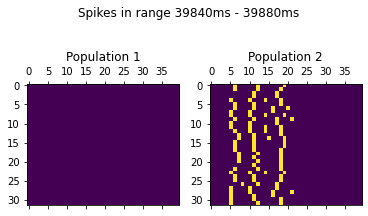

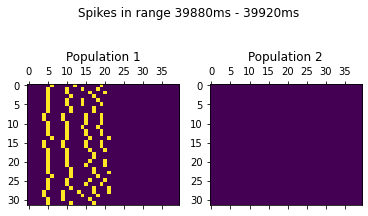

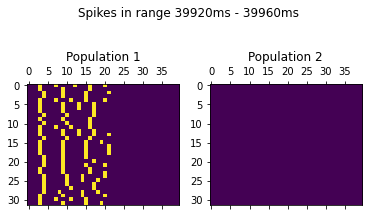

In [38]:
# x = 999
for x in range(990, 999):
    fig, (ax1, ax2) = plt.subplots(1, 2)
#     print(session_class[x])
#     plt.matshow(timestep_class[x * each_session:x * each_session + each_session].unsqueeze(1).T)
    ax1.matshow(spikes["L23 | 1"][:, x * each_session:x * each_session + each_session])
    ax2.matshow(spikes["L23 | 2"][:, x * each_session:x * each_session + each_session])
    fig.suptitle(f'Spikes in range {x * each_session}ms - {x * each_session + each_session}ms')
    ax1.set_title("Population 1")
    ax2.set_title("Population 2")

# Save Model And Notebook

In [54]:
%%javascript
function custom_kernel_ready_handler() {
    require(["base/js/namespace"],function(Jupyter) {
        Jupyter.notebook.save_checkpoint();
    });
    IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')
}

function handle_kernel_ready() {
    // Create a nb_name variable with the name of the notebook
     console.log('kernel_ready.Kernel: handle_kernel_ready() was triggered!');
     custom_kernel_ready_handler();

     Jupyter.notebook.events.one('kernel_ready.Kernel', () => {
         //this recursive behavior is esential for `restart` kernel
         handle_kernel_ready();
    });
}

Jupyter.notebook.events.one('kernel_ready.Kernel', () => {
     handle_kernel_ready();
});

handle_kernel_ready();

<IPython.core.display.Javascript object>

In [55]:
c1_with_input.save(f'models/{model_name}.pt')

In [56]:
import os
command = os.popen(f"jupyter-nbconvert --to html ./{nb_name} --stdout > models/{model_name}.html")